In [2]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   
device

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


device(type='cuda', index=0)

In [3]:
data = pd.read_csv('AI_Human.csv')

In [4]:
data['generated'] = data['generated'].astype(int)
print(data.shape)
df0_text = data[data['generated'] == 0].copy()
df1_ai = data[data['generated'] == 1].copy()
df0_text= df0_text[:150000]
df1_ai= df1_ai[:150000]
data = pd.concat([df0_text,df1_ai], ignore_index=True) 
print(data.shape)

(487235, 2)
(300000, 2)


In [5]:
def clean_text(text):
    cleaning_pattern = r'[^a-zA-Z\s]'

    clean_text = re.sub(cleaning_pattern, '', text)

    clean_text = clean_text.replace('\n', ' ')

    clean_text = re.sub(r'\s+', ' ', clean_text)

    return clean_text.strip()
data['text'] = data['text'].apply(clean_text)
data['text']= data['text'].str.lower()

In [6]:
data['tokenized_text'] = data['text'].apply(lambda x: word_tokenize(x))

In [7]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens
data['tokenized_text'] = data['tokenized_text'].apply(lambda x: remove_stopwords(x))


In [8]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

data['lemmatized_text'] = data['tokenized_text'].apply(lemmatize_text)

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
X = data['tokenized_text'] # When working locally, change this part to 'lemmatized_text'
y = data['generated']
X = [' '.join(doc) for doc in X]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline_bayes = Pipeline([
    ('count_vectorizer', CountVectorizer()), # Creates vectors using only word frequencies.
    ('tfidf_transformer', TfidfTransformer()), # Determines uniqueness between documents and highlights important words.
    ('naive_bayes', MultinomialNB())]) # Model

pipeline_bayes.fit(X_train, y_train)
y_pred_naive_bayes = pipeline_bayes.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_naive_bayes)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_naive_bayes, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_naive_bayes)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.95575
Precision: 0.956282646617336
Recall: 0.95575
F1 Score: 0.9557370822978025
Confusion Matrix:
[[29185   815]
 [ 1840 28160]]


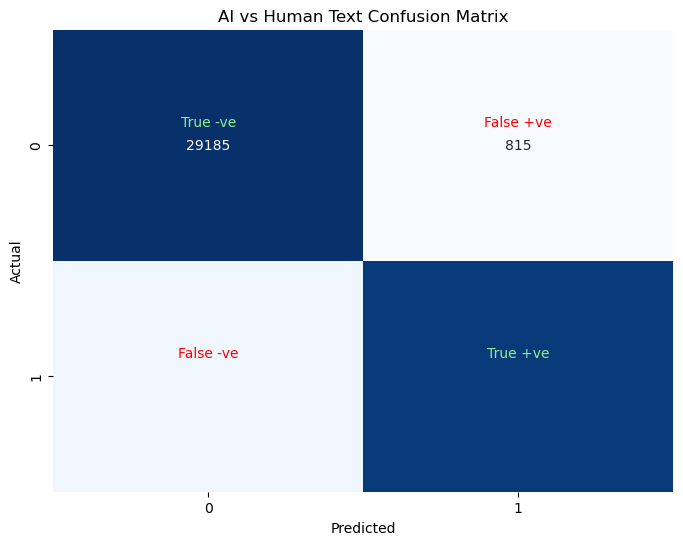

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the confusion matrix values

# Plot confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Add labels to the heatmap
plt.text(0.5, 0.4, 'True -ve', color='lightgreen', horizontalalignment='center', verticalalignment='center')
plt.text(1.5, 0.4, 'False +ve', color='red', horizontalalignment='center', verticalalignment='center')
plt.text(0.5, 1.4, 'False -ve', color='red', horizontalalignment='center', verticalalignment='center')
plt.text(1.5, 1.4, 'True +ve', color='lightgreen', horizontalalignment='center', verticalalignment='center')

plt.title("AI vs Human Text Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()